In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
from dataclasses import dataclass
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizer  
from torch.optim import AdamW



import warnings

warnings.filterwarnings("ignore")
device = "cuda" if torch.cuda.is_available() else "cpu"

# 0. Preparation
## 0.1 GPT Blocks

In [2]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 'embd_size' sized vector divided into 'num_heads' heads
        assert config.embd_size % config.num_heads == 0, f"embedding dim should be divisible by number of heads"
        self.num_heads = config.num_heads
        self.embd_size = config.embd_size
        # batched key, query, and value projections for all heads
        self.c_attn = nn.Linear(config.embd_size, 3 * config.embd_size)
        self.c_proj = nn.Linear(config.embd_size, config.embd_size)
        self.c_proj.SCALE_INIT = 1.0
        # not really a bias, more of a mask, but following OpenAI/HF naming convention
        # self.register_buffer("bias", torch.tril(torch.ones(config.context_length, config.context_length)).view(1, 1, config.context_length, config.context_length))

    def forward(self, x):
        B, T, C = x.shape
     
        qkv = self.c_attn(x)    # (B, T, 3C)
        q, k, v = qkv.split(self.embd_size, dim=-1)    # (B,T,C), (B,T,C), (B,T,C)
        q = q.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
        k = k.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
        v = v.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
    
        out = F.scaled_dot_product_attention(q, k, v, is_causal=True)    # (B,nh,T,hs)
        out = out.transpose(1, 2).contiguous().view(B, T, C)    # (B,nh,T,hs) --> (B,T,nh,hs) --> (B,T,C=nh*hs)
        out = self.c_proj(out)    # (B,T,C) --> (B,T,C)
        return out


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embd_size, 4 * config.embd_size)
        self.gelu = nn.GELU(approximate='tanh')    # approximate='tanh' used to try to reproduce gpt2 paper
        self.c_proj = nn.Linear(4 * config.embd_size, config.embd_size)
        self.c_proj.SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class Block(nn.Module):
    """ Transformer Encoder block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embd_size)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.embd_size)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    

In [ ]:
class GPTLM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.config.vocab_size, self.config.embd_size),
            wpe = nn.Embedding(self.config.context_length, self.config.embd_size),
            h = nn.ModuleList([Block(self.config) for _ in range(self.config.num_layers)]),
            ln_f = nn.LayerNorm(self.config.embd_size)
        ))
        # language modeling head
        self.lm_head = nn.Linear(self.config.embd_size, self.config.vocab_size, bias=False)
        # weight sharing scheme (reduces 768*50267=~40M params, fewer params, more efficient)
        self.transformer.wte.weight = self.lm_head.weight
        # init params (iterates over all submodules and applies _init_weights)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'SCALE_INIT'):
                std /= (2 * self.config.num_layers)**0.5
            torch.nn.init.normal_(module.weight, mean=0, std=std)    # as per openai gpt-2 source code
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.context_length, f'sequence length {T} should be <= {self.config.context_length}'
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)    # (T,)
        pos_embd = self.transformer.wpe(pos)    # (T, embd_size)
        tok_embd = self.transformer.wte(idx)    # (B, T, embd_size)
        x = pos_embd + tok_embd    # (B, T, embd_size)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)    # (B, T, embd_size)
        logits = self.lm_head(x)    # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1), ignore_index=-100)
        return logits, loss

    def generate(self, input_ids, max_length=65): ## only to generate the <好评> or <差评>
        gen_tokens = input_ids
        while gen_tokens.shape[-1] < max_length:
            with torch.inference_mode():
                logits, loss = self(gen_tokens.to(device))
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                next_tok = torch.argmax(probs, dim=-1, keepdim=True)
                gen_tokens = torch.cat([gen_tokens, next_tok], dim=-1)
        return gen_tokens
    
    @classmethod
    def from_pretrained(cls, model_type):
        """ Loads pretrained GPT2 model weights from huggingface """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'uer/gpt2-distil-chinese-cluecorpussmall'}
        from transformers import GPT2LMHeadModel
        print(f"loading weights from pretrained gpt: {model_type}")

        config_args = {
            'uer/gpt2-distil-chinese-cluecorpussmall': dict(num_layers=6, num_heads=12, embd_size=768),    # 82M params
            'gpt2': dict(num_layers=12, num_heads=12, embd_size=768),    # 124M params
            'gpt2-medium': dict(num_layers=24, num_heads=16, embd_size=1024),    # 350M params
            'gpt2-large': dict(num_layers=36, num_heads=20, embd_size=1280),    # 774M params
            'gpt2-xl': dict(num_layers=48, num_heads=25, embd_size=1600),    # 1558M params
        }[model_type]
        config_args['vocab_size'] = 21128
        config_args['context_length'] = 1024

        # create a from-scratch minGPT model
        config = GPTConfig(**config_args)
        model = GPTLM(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]

        # init a huggingface transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')]
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        assert len(sd_keys) == len(sd_keys_hf), f"mismatched keys {len(sd_keys)} != {len(sd_keys_hf)}"

        # copy while ensuring all parameters are aligned in names and shape
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # need to transpose Conv1D weights
                assert sd_hf[k].shape[::-1]  == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].T)
            else:
                # print(k, sd_hf[k].shape, sd[k].shape)
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model
    

## 0.2 Tokenizer, Dataset and Dataloader
1. We use **BertTokenizer** found on *huggingface* in order to tokenize Chinese text.
2. In order to better classify the sentiment, we add four special tokens to the beginning of each text:`<好评>`, `<差评>`, `<review>`, `<sentiment>`.
3. We may find out that in the dataset, bias is quite common, where the positive samples are much more than the negative samples(4305-695). In order to balance the dataset, we simply **over-sample** the negative samples.

In [3]:
tokenizer = BertTokenizer.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")

## Important!!!!! Add special tokens in order to train the model

special_tokens_dict = {"additional_special_tokens": ["<好评>", "<差评>", "<review>", "<sentiment>"]}
tokenizer.add_special_tokens(special_tokens_dict)
len(tokenizer)

21132

In [5]:
df = pd.read_csv("./reviews.csv")


df_positive = df[df['sentiment'] == 1]
df_negative = df[df['sentiment'] == 0]
n_positive = len(df_positive)

df_negative_over = df_negative.sample(n=n_positive, replace=True, random_state=42)
df = pd.concat([df_positive, df_negative_over])


train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

In [4]:
def preprocess_sample(review_text, label, tokenizer, max_length=64):
    label_str = "<好评>" if label == 1 else "<差评>"
    prompt = f"<review>\n{review_text}\n<sentiment>\n"
    full_text = prompt + label_str
    encoding = tokenizer(full_text,
                         return_tensors="pt",
                         padding="max_length",  
                         max_length=max_length,
                         truncation=True, add_special_tokens=False)
    
    input_ids = encoding.input_ids.squeeze(0)
    labels = input_ids.clone()

    
    prompt_encoding = tokenizer(prompt, return_tensors="pt", add_special_tokens=False)
    prompt_length = prompt_encoding.input_ids.shape[1]
    
    
    labels = labels[1:]
    # add a 0 at the end of labels
    labels = torch.cat([labels, torch.tensor([0])])
    labels[:prompt_length-1] = -100 # set to -100 to ignore loss
    if prompt_length < 64:
        input_ids[prompt_length] = 0

    
    
    return {
        "input_ids": input_ids,
        "labels": labels,
        "prompt_length": prompt_length
    }
    
class TrainDataset(Dataset):
    def __init__(self, dataframe, tokenizer=None, max_length=64):
        self.df = dataframe
        self.max_length = max_length
        if tokenizer is not None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = BertTokenizer.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")
            self.tokenizer.add_special_tokens({"additional_special_tokens": ["<好评>", "<差评>", "<review>", "<sentiment>"]})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        review = self.df.iloc[index]['review']
        sentiment = self.df.iloc[index]['sentiment']  # 1 or 0

     
        return preprocess_sample(review, sentiment, self.tokenizer, self.max_length)

class ValidDataset(Dataset):
    def __init__(self, dataframe, tokenizer=None, max_length=64):
        self.df = dataframe
        self.max_length = max_length
        if tokenizer is not None:
            self.tokenizer = tokenizer
        else:
            self.tokenizer = BertTokenizer.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")
            self.tokenizer.add_special_tokens({"additional_special_tokens": ["<好评>", "<差评>", "<review>", "<sentiment>"]})

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        review_text = self.df.iloc[index]['review']
        label = self.df.iloc[index]['sentiment']  # 1 or 0
        label_str = "<好评>" if label == 1 else "<差评>"
        prompt = f"<review>\n{review_text}\n<sentiment>\n"
        # full_text = prompt + label_str

        encoding = tokenizer(prompt,
                            return_tensors="pt",
                            padding="max_length",  
                            max_length=self.max_length,
                            truncation=True, add_special_tokens=False)
        
        input_ids = encoding.input_ids.squeeze(0) 
        
        attention_mask = encoding.attention_mask.squeeze(0)

        # 计算 prompt 部分的 token 数量，设置为 -100 来屏蔽其 loss
        labels = tokenizer(label_str, return_tensors="pt", add_special_tokens=False).input_ids.squeeze(0)
        return {
            "input_ids": input_ids,
            "labels": labels,
            "attention_mask": attention_mask
        }

In [75]:
trainset = TrainDataset(train_df, tokenizer)
validset = ValidDataset(val_df, tokenizer)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=True) 

# 1. GPT-2 with autoregressive 
## 1.1 Train a tiny toy GPT-2 model
**Hyperparams are listed as follows**
1. `num_layers`: 2
2. `hidden_size`: 384

In [38]:
@dataclass
class GPTConfig:
    context_length: int = 128   # max context / sequence length
    vocab_size: int = 21132    # number of tokens for bert-tokenizer + special tokens
    num_layers: int = 2
    # embd_size: int = 768   # embedding dim
    embd_size: int = 384
    num_heads: int = 12
    hidden_size: int = 384

In [39]:
config = GPTConfig()
model = GPTLM(config).to(device)

In [15]:
def evaluate(model):
    model.eval()
    total_samples = 0
    correct_preds = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    with torch.no_grad():
        for batch in validloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_size = input_ids.size(0)
            actual_lengths = attention_mask.sum(dim=1) 
    
            for i in range(batch_size):
                
                prompt_len = int(actual_lengths[i].item())
                single_input_ids = input_ids[i][:prompt_len].unsqueeze(0)
                single_mask = attention_mask[i][:prompt_len].unsqueeze(0)
                generated_ids = model.generate(single_input_ids, max_length=single_input_ids.shape[1]+1)
                answer_ids = generated_ids[0, prompt_len:prompt_len+1]

                # print(f"generated_ids: {generated_ids}")
                # print(f"answer_ids: {answer_ids}")
                # print(f"labels: {labels[i]}")

    
                true_text = labels[i]
                # print(f"answer_ids: {answer_ids}, true_text: {true_text}")
     
                total_samples += 1
                
                # 这里简单判断：如果预测结果中包含真实标签，就认为预测正确
                if true_text == answer_ids:
                    correct_preds += 1
                if true_text == 21128 and answer_ids == 21128:
                    TP += 1
                elif true_text == 21129 and answer_ids == 21129:
                    TN += 1
                elif true_text == 21128 and answer_ids != 21128:
                    FN += 1
                elif true_text == 21129 and answer_ids != 21129:
                    FP += 1
                    

    metrics = {}                          
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    metrics['accuracy'] = accuracy
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1_score

    model.train()
    return metrics
                
            
def train(model, optimizer, num_epochs):
    model.train()
    for epoch in trange(num_epochs):

        for step, batch in enumerate(trainloader):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits, loss = model(input_ids, labels)
            
            loss.backward()
            optimizer.step()
            
            if step % 50 == 0:
                print(f"Epoch: {epoch} Step {step}: Loss = {loss.item():.6f}")
        
        metrics = evaluate(model)
        print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")
        
        model.train()

    print("Training complete!")

In [46]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
train(model, optimizer, num_epochs=15)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0 Step 0: Loss = 8.836351
Epoch: 0 Step 50: Loss = 1.503196
Epoch: 0 Step 100: Loss = 0.642614


  7%|▋         | 1/15 [00:05<01:11,  5.13s/it]

Validation Accuracy: 0.4657
Epoch: 1 Step 0: Loss = 0.451556
Epoch: 1 Step 50: Loss = 0.239723
Epoch: 1 Step 100: Loss = 0.145998


 13%|█▎        | 2/15 [00:09<01:03,  4.87s/it]

Validation Accuracy: 0.6330
Epoch: 2 Step 0: Loss = 0.123044
Epoch: 2 Step 50: Loss = 0.086820
Epoch: 2 Step 100: Loss = 0.069500


 20%|██        | 3/15 [00:14<00:58,  4.90s/it]

Validation Accuracy: 0.6899
Epoch: 3 Step 0: Loss = 0.061467
Epoch: 3 Step 50: Loss = 0.050893
Epoch: 3 Step 100: Loss = 0.042483


 27%|██▋       | 4/15 [00:19<00:53,  4.90s/it]

Validation Accuracy: 0.7433
Epoch: 4 Step 0: Loss = 0.038326
Epoch: 4 Step 50: Loss = 0.032568
Epoch: 4 Step 100: Loss = 0.026368


 33%|███▎      | 5/15 [00:24<00:49,  4.92s/it]

Validation Accuracy: 0.8269
Epoch: 5 Step 0: Loss = 0.024451
Epoch: 5 Step 50: Loss = 0.020424
Epoch: 5 Step 100: Loss = 0.019085


 40%|████      | 6/15 [00:29<00:43,  4.87s/it]

Validation Accuracy: 0.8548
Epoch: 6 Step 0: Loss = 0.017184
Epoch: 6 Step 50: Loss = 0.016875
Epoch: 6 Step 100: Loss = 0.011944


 47%|████▋     | 7/15 [00:34<00:38,  4.86s/it]

Validation Accuracy: 0.8664
Epoch: 7 Step 0: Loss = 0.011101
Epoch: 7 Step 50: Loss = 0.012749
Epoch: 7 Step 100: Loss = 0.009531


 53%|█████▎    | 8/15 [00:39<00:34,  4.89s/it]

Validation Accuracy: 0.8908
Epoch: 8 Step 0: Loss = 0.009539
Epoch: 8 Step 50: Loss = 0.007852
Epoch: 8 Step 100: Loss = 0.007340


 60%|██████    | 9/15 [00:44<00:29,  4.89s/it]

Validation Accuracy: 0.8908
Epoch: 9 Step 0: Loss = 0.008330
Epoch: 9 Step 50: Loss = 0.006260
Epoch: 9 Step 100: Loss = 0.007418


 67%|██████▋   | 10/15 [00:49<00:24,  4.94s/it]

Validation Accuracy: 0.8955
Epoch: 10 Step 0: Loss = 0.005496
Epoch: 10 Step 50: Loss = 0.005173
Epoch: 10 Step 100: Loss = 0.004884


 73%|███████▎  | 11/15 [00:54<00:19,  5.00s/it]

Validation Accuracy: 0.9059
Epoch: 11 Step 0: Loss = 0.005203
Epoch: 11 Step 50: Loss = 0.004815
Epoch: 11 Step 100: Loss = 0.004165


 80%|████████  | 12/15 [00:59<00:15,  5.01s/it]

Validation Accuracy: 0.8978
Epoch: 12 Step 0: Loss = 0.003840
Epoch: 12 Step 50: Loss = 0.003637
Epoch: 12 Step 100: Loss = 0.003367


 87%|████████▋ | 13/15 [01:04<00:10,  5.04s/it]

Validation Accuracy: 0.9024
Epoch: 13 Step 0: Loss = 0.003296
Epoch: 13 Step 50: Loss = 0.003331
Epoch: 13 Step 100: Loss = 0.002956


 93%|█████████▎| 14/15 [01:09<00:05,  5.04s/it]

Validation Accuracy: 0.9013
Epoch: 14 Step 0: Loss = 0.002926
Epoch: 14 Step 50: Loss = 0.002646
Epoch: 14 Step 100: Loss = 0.003585


100%|██████████| 15/15 [01:14<00:00,  4.97s/it]

Validation Accuracy: 0.9013
Training complete!


In [47]:
torch.save(model.state_dict(), "toy-gpt2-9013.pt")

In [42]:
model.load_state_dict(torch.load("toy-gpt2-9013.pt"))
model.eval()
evaluate(model)

{'accuracy': 0.9012775842044135,
 'precision': 0.9101654846335697,
 'recall': 0.8912037037037037,
 'f1_score': 0.9005847953216374}

In [28]:
def predict_sentiment(review_text, model, tokenizer, device, gen_max_length=1):
    prompt = f"<review>\n{review_text}\n<sentiment>\n"
    
    encoding = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, add_special_tokens=False)
    input_ids = encoding.input_ids.to(device)
    print(input_ids)

    # print(attention_mask)
    output_ids = model.generate(
        input_ids,
        max_length=input_ids.shape[1] + gen_max_length,
    )

    print(output_ids)
    generated_tokens = output_ids[0][input_ids.shape[1]:]

    generated_text = tokenizer.decode(generated_tokens)
    
    return generated_text.strip()

In [50]:
comment = "爱超越理智是唯一的真理"
model.eval()
result = predict_sentiment(comment, model, tokenizer, device)
print("Prediction:", result)

tensor([[21130,  4263,  6631,  6632,  4415,  3255,  3221,  1546,   671,  4638,
          4696,  4415, 21131]], device='cuda:0')
tensor([[21130,  4263,  6631,  6632,  4415,  3255,  3221,  1546,   671,  4638,
          4696,  4415, 21131, 21128]], device='cuda:0')
Prediction: <好评>


## 1.2 Post-train a original GPT-2 117M(GPT small) with pretrained weights.
> In this part, we first load the pretrained weights from huggingface and extract the weights of the model. Then we load the weights into our own model and try to post-train it.

In [17]:
@dataclass
class GPTConfig:
    context_length: int = 1024   # max context / sequence length
    vocab_size: int = 21132    # number of tokens for bert-tokenizer + special tokens
    num_layers: int = 6
    embd_size: int = 768
    num_heads: int = 12
    hidden_size: int = 768





In [75]:
from transformers import GPT2LMHeadModel
model = GPT2LMHeadModel.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")
model.resize_token_embeddings(len(tokenizer))
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
torch.save(model.state_dict(), "pre-trained.pt")

In [ ]:
config = GPTConfig()
model = GPTLM(config)


def load_pretrained_gpt2(model_path: str):
    """
    从本地的 Hugging Face GPT-2 预训练权重加载到自定义的 GPTLM 模型中。
    :param model_path: 本地的 GPT-2 预训练模型文件路径（.pt 文件）
    :return: 加载完毕的 GPTLM 模型
    """

  
    print(f"Loading pretrained GPT-2 weights from {model_path}...")
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))

  
    if "state_dict" in checkpoint:
        checkpoint = checkpoint["state_dict"]  

    print(f"Checkpoint keys loaded: {len(checkpoint.keys())}")


    config_args = dict(
        num_layers=6,    
        num_heads=12,     
        embd_size=768,    
        vocab_size=21132, 
        context_length=1024  
    )
    
    config = GPTConfig(**config_args)
    model = GPTLM(config)


    model_sd = model.state_dict()
    
    
    checkpoint = {k: v for k, v in checkpoint.items() if not k.endswith('.attn.bias') and not k.endswith('.attn.masked_bias')}
    

    print(f"Filtered checkpoint keys: {len(checkpoint.keys())}, Model keys: {len(model_sd.keys())}")

    transposed_layers = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
    
    for k in checkpoint:
        if k in model_sd:
            if any(k.endswith(w) for w in transposed_layers):
   
                checkpoint[k] = checkpoint[k].T


    model.load_state_dict(checkpoint, strict=False) 
    print("Weights successfully loaded!")


    model.eval()
    print("Model is ready for inference.")
    
    return model

gpt_model = load_pretrained_gpt2("pre-trained.pt").to(device)


Loading pretrained GPT-2 weights from pre-trained.pt...
Checkpoint keys loaded: 77
Filtered checkpoint keys: 77, Model keys: 77
Weights successfully loaded!
Model is ready for inference.


In [36]:
trainset = TrainDataset(train_df, tokenizer)
validset = ValidDataset(val_df, tokenizer, max_length=128)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=True)

In [78]:
optimizer = torch.optim.AdamW(gpt_model.parameters(), lr=5e-5)
train(gpt_model, optimizer, num_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 Step 0: Loss = 9.970535
Epoch: 0 Step 50: Loss = 0.015316
Epoch: 0 Step 100: Loss = 0.018852


 20%|██        | 1/5 [00:17<01:10, 17.52s/it]

Validation Accuracy: 0.7828
Epoch: 1 Step 0: Loss = 0.012945
Epoch: 1 Step 50: Loss = 0.007405
Epoch: 1 Step 100: Loss = 0.009285


 40%|████      | 2/5 [00:33<00:49, 16.50s/it]

Validation Accuracy: 0.8862
Epoch: 2 Step 0: Loss = 0.006904
Epoch: 2 Step 50: Loss = 0.005140
Epoch: 2 Step 100: Loss = 0.001718


 60%|██████    | 3/5 [00:49<00:32, 16.22s/it]

Validation Accuracy: 0.9245
Epoch: 3 Step 0: Loss = 0.002354
Epoch: 3 Step 50: Loss = 0.002606
Epoch: 3 Step 100: Loss = 0.001019


 80%|████████  | 4/5 [01:05<00:16, 16.17s/it]

Validation Accuracy: 0.9477
Epoch: 4 Step 0: Loss = 0.000926
Epoch: 4 Step 50: Loss = 0.000464
Epoch: 4 Step 100: Loss = 0.000355


100%|██████████| 5/5 [01:21<00:00, 16.30s/it]

Validation Accuracy: 0.9408
Training complete!


In [83]:
torch.save(gpt_model.state_dict(), "gpt2-small.pt")

In [31]:
comment = "以为在寻找，其实在逃避，保持距离，，。"
gpt_model.eval()
result = predict_sentiment(comment, gpt_model, tokenizer, device)
print("预测结果:", result)

tensor([[21130,   809,   711,  1762,  2192,  2823,  8024,  1071,  2141,  1762,
          6845,  6912,  8024,   924,  2898,  6655,  4895,  8024,  8024,   511,
         21131]], device='cuda:0')
tensor([[21130,   809,   711,  1762,  2192,  2823,  8024,  1071,  2141,  1762,
          6845,  6912,  8024,   924,  2898,  6655,  4895,  8024,  8024,   511,
         21131, 21128]], device='cuda:0')
预测结果: <好评>


In [30]:
gpt_model.load_state_dict(torch.load("gpt2-small.pt"))

<All keys matched successfully>

In [37]:
evaluate(gpt_model)

{'accuracy': 0.9407665505226481,
 'precision': 0.954653937947494,
 'recall': 0.9259259259259259,
 'f1_score': 0.9400705052878966}

# 2. GPT-2 with classification head
> This part is a another try which is mentioned in GPT-1 paper. In this part, the GPT model works as a feature extractor to extract the features of the text, and then we add a classification head to classify the sentiment.

Note that in this part, we do not add the special tokens to tokenizers. Instead, we use the **last hidden state of the model** to work as a **encoder**.

1. We can see that with the help of the **classification head**, the model can achieve a better performance than the autoregressive model.
2. Only train the classification with the pretrained weights, the model performs poor(only a little better than random guess). This is maybe because of the **feature extractor** is not good enough.

In [43]:
class GPTDataset(Dataset):

    def __init__(self) -> None:
        super().__init__()
        self.data = df
        self.data = self.data.dropna()

    def __getitem__(self, index):
        return self.data.iloc[index]["review"], self.data.iloc[index]["sentiment"]
    
    def __len__(self):
        return len(self.data)
    
dataset = GPTDataset()
trainset, validset = random_split(dataset, lengths=[0.9, 0.1])
len(trainset), len(validset)


(7749, 861)

In [44]:
def collate_func(batch):
    texts, sentiments = [], []
    for text, sentiment in batch:
        texts.append(text)
        sentiments.append(sentiment)
        
    inputs = tokenizer(texts, max_length = 64, padding="max_length", truncation=True, return_tensors="pt")
    inputs['sentiments'] = torch.tensor(sentiments)
    # inputs.pop("token_type_ids")
    # inputs.pop("attention_mask")
    return inputs

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, collate_fn=collate_func)
validloader = DataLoader(validset, batch_size=64, shuffle=False, collate_fn=collate_func)

In [ ]:
@dataclass
class GPTConfig:
    context_length: int = 1024    # max context / sequence length
    vocab_size: int = 21128    # number of tokens for bert-tokenizer
    num_layers: int = 12
    embd_size: int = 768    # embedding dim
    num_heads: int = 12
    hidden_size: int = 768

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.config.vocab_size, self.config.embd_size),
            wpe = nn.Embedding(self.config.context_length, self.config.embd_size),
            h = nn.ModuleList([Block(self.config) for _ in range(self.config.num_layers)]),
            ln_f = nn.LayerNorm(self.config.embd_size)
        ))
        self.transformer.wte.weight =  nn.Linear(self.config.embd_size, self.config.vocab_size, bias=False).weight
        
        # init params (iterates over all submodules and applies _init_weights)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'SCALE_INIT'):
                std /= (2 * self.config.num_layers)**0.5
            torch.nn.init.normal_(module.weight, mean=0, std=std)    # as per openai gpt-2 source code
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.context_length, f'sequence length {T} should be <= {self.config.context_length}'
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)    # (T,)
        pos_embd = self.transformer.wpe(pos)    # (T, embd_size)
        tok_embd = self.transformer.wte(idx)    # (B, T, embd_size)
        x = pos_embd + tok_embd    # (B, T, embd_size)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)    # (B, T, embd_size)
        # logits = self.lm_head(x)    # (B, T, vocab_size)
        
        # loss = None
        # if targets is not None:
        #     loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
        # return logits, loss
        return x

    @classmethod
    def from_pretrained(cls, model_type):
        """ Loads pretrained GPT2 model weights from huggingface """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl', 'uer/gpt2-distil-chinese-cluecorpussmall'}
        from transformers import GPT2Model, GPT2LMHeadModel
        print(f"loading weights from pretrained gpt: {model_type}")

        config_args = {
            'uer/gpt2-distil-chinese-cluecorpussmall': dict(num_layers=6, num_heads=12, embd_size=768),    # 82M params
            'gpt2': dict(num_layers=12, num_heads=12, embd_size=768),    # 124M params
            'gpt2-medium': dict(num_layers=24, num_heads=16, embd_size=1024),    # 350M params
            'gpt2-large': dict(num_layers=36, num_heads=20, embd_size=1280),    # 774M params
            'gpt2-xl': dict(num_layers=48, num_heads=25, embd_size=1600),    # 1558M params
        }[model_type]
        # config_args['vocab_size'] = 50257
        config_args['vocab_size'] = 21128
        config_args['context_length'] = 1024

        # create a from-scratch minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')]

        # init a huggingface transformers model
        
        # model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        model_hf = GPT2Model.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')]
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')]
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        assert len(sd_keys) == len(sd_keys_hf), f"mismatched keys {len(sd_keys)} != {len(sd_keys_hf)}"

        # copy while ensuring all parameters are aligned in names and shape
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # need to transpose Conv1D weights
                assert sd_hf[k].shape[::-1]  == sd["transformer." + k].shape
                with torch.no_grad():
                    sd["transformer." + k].copy_(sd_hf[k].T)
            else:
                assert sd_hf[k].shape == sd["transformer." + k].shape
                with torch.no_grad():
                    sd["transformer." + k].copy_(sd_hf[k])
        return model

class GPT2ForClassification(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.gpt2 = base_model
        self.dropout = nn.Dropout(0.1)
        self.classifer = nn.Linear(base_model.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask=None):
        outputs = self.gpt2(input_ids)
        hidden_state = outputs
        last_hidden_state = hidden_state[:, -1, :]
        output = self.dropout(last_hidden_state)
        logits = self.classifer(output)
        return logits
        
tokenizer = BertTokenizer.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")

In [53]:
def evaluate(model):
    model.eval()
    acc_num = 0
    TP, FP, FN, TN = 0, 0, 0, 0  # 初始化四个指标
    
    with torch.inference_mode():
        for batch in validloader:
            if torch.cuda.is_available():
                batch = {k: v.cuda() for k, v in batch.items()}
            
            # 获取模型预测
            output = model(batch["input_ids"], attention_mask=batch["attention_mask"])
            pred = torch.argmax(output, dim=-1)  # 获取预测类别
            labels = batch["sentiments"].long()  # 真实标签
            
            # 计算准确预测的数量
            acc_num += (pred == labels).float().sum().item()
            
            # 计算 TP, FP, FN, TN
            TP += ((pred == 1) & (labels == 1)).sum().item()
            FP += ((pred == 1) & (labels == 0)).sum().item()
            FN += ((pred == 0) & (labels == 1)).sum().item()
            TN += ((pred == 0) & (labels == 0)).sum().item()

    # 计算各项指标
    accuracy = acc_num / len(validset)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # 避免除 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # 避免除 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0  # 避免除 0

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

def train(model, epoch=3, log_step=100, optimizer=None):
    global_step = 0
    critierion = nn.CrossEntropyLoss()
    for ep in trange(epoch):
        model.train()

        for batch in trainloader:
            if torch.cuda.is_available():
                batch = {k: v.cuda() for k, v in batch.items()}
            optimizer.zero_grad()
            logits = model(batch["input_ids"], attention_mask=batch["attention_mask"])
            loss = critierion(logits, batch["sentiments"])
            loss.backward()
            optimizer.step()
            
            if global_step % log_step == 0:
                print(f"ep: {ep+1}, global_step: {global_step}, loss: {loss.item()}")
                
            global_step += 1
        acc = evaluate(model)
        print(f"ep: {ep+1}, acc: {acc}")

In [64]:
config = GPTConfig()
baseModel = GPT(config)
model = GPT2ForClassification(baseModel, 2).to(device)


In [56]:
optimizer = AdamW(model.parameters(), lr=1e-5)

train(model, 8, 100, optimizer)

  0%|          | 0/8 [00:00<?, ?it/s]

ep: 1, global_step: 0, loss: 0.6732971668243408
ep: 1, global_step: 100, loss: 0.7043816447257996
ep: 1, global_step: 200, loss: 0.6535121202468872


 12%|█▎        | 1/8 [00:25<02:57, 25.42s/it]

ep: 1, acc: {'accuracy': 0.7874564459930313, 'precision': 0.7573221757322176, 'recall': 0.8438228438228438, 'f1_score': 0.7982359426681367}
ep: 2, global_step: 300, loss: 0.3386944532394409
ep: 2, global_step: 400, loss: 0.38297000527381897


 25%|██▌       | 2/8 [00:50<02:31, 25.20s/it]

ep: 2, acc: {'accuracy': 0.8490127758420442, 'precision': 0.9657320872274143, 'recall': 0.7226107226107226, 'f1_score': 0.8266666666666667}
ep: 3, global_step: 500, loss: 0.23382598161697388
ep: 3, global_step: 600, loss: 0.4337620437145233
ep: 3, global_step: 700, loss: 0.019441373646259308


 38%|███▊      | 3/8 [01:15<02:06, 25.21s/it]

ep: 3, acc: {'accuracy': 0.9210220673635308, 'precision': 0.9787798408488063, 'recall': 0.8601398601398601, 'f1_score': 0.9156327543424317}
ep: 4, global_step: 800, loss: 0.06591061502695084
ep: 4, global_step: 900, loss: 0.1536676436662674


 50%|█████     | 4/8 [01:41<01:42, 25.57s/it]

ep: 4, acc: {'accuracy': 0.9337979094076655, 'precision': 0.984375, 'recall': 0.8811188811188811, 'f1_score': 0.9298892988929889}
ep: 5, global_step: 1000, loss: 0.1606305092573166
ep: 5, global_step: 1100, loss: 0.22378171980381012
ep: 5, global_step: 1200, loss: 0.26578760147094727


 62%|██████▎   | 5/8 [02:11<01:21, 27.08s/it]

ep: 5, acc: {'accuracy': 0.9256678281068524, 'precision': 0.9815303430079155, 'recall': 0.8671328671328671, 'f1_score': 0.9207920792079207}
ep: 6, global_step: 1300, loss: 0.22605058550834656
ep: 6, global_step: 1400, loss: 0.07575403898954391


 75%|███████▌  | 6/8 [02:41<00:56, 28.03s/it]

ep: 6, acc: {'accuracy': 0.9558652729384437, 'precision': 0.9851116625310173, 'recall': 0.9254079254079254, 'f1_score': 0.954326923076923}
ep: 7, global_step: 1500, loss: 0.0030954231042414904
ep: 7, global_step: 1600, loss: 0.0073699988424777985
ep: 7, global_step: 1700, loss: 0.00184864760376513


 88%|████████▊ | 7/8 [03:13<00:29, 29.22s/it]

ep: 7, acc: {'accuracy': 0.9407665505226481, 'precision': 0.9947643979057592, 'recall': 0.8857808857808858, 'f1_score': 0.93711467324291}
ep: 8, global_step: 1800, loss: 0.06904040277004242
ep: 8, global_step: 1900, loss: 0.010874311439692974


100%|██████████| 8/8 [03:45<00:00, 28.23s/it]

ep: 8, acc: {'accuracy': 0.9477351916376306, 'precision': 0.9897959183673469, 'recall': 0.9044289044289044, 'f1_score': 0.9451887941534713}


In [57]:
comment = "就是那些一问一间的小时光因为再也不会有而显得珍贵。最后的最后，是怀念你。"
id2_label = {0: "差评！", 1: "好评！"}
model.eval()
# tokenizer(sen)['input_ids']
with torch.inference_mode():
    inputs = tokenizer(comment, return_tensors="pt")
    # inputs = {k: v.cuda() for k, v in inputs.items()}
    logits = model(inputs['input_ids'].cuda(), attention_mask=inputs['attention_mask'].cuda())
    pred = torch.argmax(logits, dim=1)
    print(f"Input：{comment}\nPrediction:{id2_label.get(pred.item())}")

Input：就是那些一问一间的小时光因为再也不会有而显得珍贵。最后的最后，是怀念你。
Prediction:好评！


In [96]:
torch.save(model.state_dict(), "GPT2-small_with_classification_head.pt")

In [62]:
model.load_state_dict(torch.load("GPT2-small_with_classification_head.pt"))
model.eval()
evaluate(model)

{'accuracy': 0.991869918699187,
 'precision': 0.9884259259259259,
 'recall': 0.9953379953379954,
 'f1_score': 0.9918699186991871}

# 3. Ablation Study and further exploration
## 3.1 Freezing the pretrained weights
However, we can see that the model doesn't perform well. This is maybe because the **feature extractor** is not good enough. We can see that the model only performs a little better than random guess.

In [68]:
config = GPTConfig()
baseModel = GPT(config)
baseModel = baseModel.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")

model = GPT2ForClassification(baseModel, 2).to(device)
"Only train the last layer"
for param in model.gpt2.parameters():
    param.requires_grad = False 

loading weights from pretrained gpt: uer/gpt2-distil-chinese-cluecorpussmall


In [69]:
optimizer = AdamW(model.parameters(), lr=1e-5)

train(model, 6, 100, optimizer)

  0%|          | 0/6 [00:00<?, ?it/s]

ep: 1, global_step: 0, loss: 0.7162313461303711
ep: 1, global_step: 100, loss: 0.7460144758224487
ep: 1, global_step: 200, loss: 0.7517682313919067


 17%|█▋        | 1/6 [00:04<00:22,  4.48s/it]

ep: 1, acc: {'accuracy': 0.4715447154471545, 'precision': 0.47703180212014135, 'recall': 0.6293706293706294, 'f1_score': 0.5427135678391959}
ep: 2, global_step: 300, loss: 0.7182636857032776
ep: 2, global_step: 400, loss: 0.6732214093208313


 33%|███▎      | 2/6 [00:08<00:17,  4.36s/it]

ep: 2, acc: {'accuracy': 0.49825783972125437, 'precision': 0.4974182444061962, 'recall': 0.6736596736596736, 'f1_score': 0.5722772277227722}
ep: 3, global_step: 500, loss: 0.6834787726402283
ep: 3, global_step: 600, loss: 0.73627769947052
ep: 3, global_step: 700, loss: 0.7711343765258789


 50%|█████     | 3/6 [00:13<00:12,  4.31s/it]

ep: 3, acc: {'accuracy': 0.519163763066202, 'precision': 0.5272727272727272, 'recall': 0.337995337995338, 'f1_score': 0.4119318181818182}
ep: 4, global_step: 800, loss: 0.730109691619873
ep: 4, global_step: 900, loss: 0.771811842918396


 67%|██████▋   | 4/6 [00:17<00:08,  4.24s/it]

ep: 4, acc: {'accuracy': 0.5284552845528455, 'precision': 0.5253863134657837, 'recall': 0.5547785547785548, 'f1_score': 0.5396825396825397}
ep: 5, global_step: 1000, loss: 0.7227887511253357
ep: 5, global_step: 1100, loss: 0.6726238131523132
ep: 5, global_step: 1200, loss: 0.6882484555244446


 83%|████████▎ | 5/6 [00:21<00:04,  4.16s/it]

ep: 5, acc: {'accuracy': 0.5319396051103368, 'precision': 0.5287610619469026, 'recall': 0.5571095571095571, 'f1_score': 0.5425652667423383}
ep: 6, global_step: 1300, loss: 0.6368072032928467
ep: 6, global_step: 1400, loss: 0.6140695810317993


100%|██████████| 6/6 [00:25<00:00,  4.18s/it]

ep: 6, acc: {'accuracy': 0.5563298490127758, 'precision': 0.5623342175066313, 'recall': 0.49417249417249415, 'f1_score': 0.5260545905707196}


In [70]:
evaluate(model)

{'accuracy': 0.5563298490127758,
 'precision': 0.5623342175066313,
 'recall': 0.49417249417249415,
 'f1_score': 0.5260545905707196}

## 3.2 GPT block without FFN
> In this part, we try to remove the FFN layer in the GPT block and see the performance of the model.

In [13]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 'embd_size' sized vector divided into 'num_heads' heads
        assert config.embd_size % config.num_heads == 0, f"embedding dim should be divisible by number of heads"
        self.num_heads = config.num_heads
        self.embd_size = config.embd_size
        # batched key, query, and value projections for all heads
        self.c_attn = nn.Linear(config.embd_size, 3 * config.embd_size)
        self.c_proj = nn.Linear(config.embd_size, config.embd_size)
        self.c_proj.SCALE_INIT = 1.0
        # not really a bias, more of a mask, but following OpenAI/HF naming convention
        # self.register_buffer("bias", torch.tril(torch.ones(config.context_length, config.context_length)).view(1, 1, config.context_length, config.context_length))

    def forward(self, x):
        B, T, C = x.shape
     
        qkv = self.c_attn(x)    # (B, T, 3C)
        q, k, v = qkv.split(self.embd_size, dim=-1)    # (B,T,C), (B,T,C), (B,T,C)
        q = q.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
        k = k.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
        v = v.view(B, T, self.num_heads, self.embd_size // self.num_heads).transpose(1, 2)    # (B,nh,T,hs)
    
        out = F.scaled_dot_product_attention(q, k, v, is_causal=True)    # (B,nh,T,hs)
        out = out.transpose(1, 2).contiguous().view(B, T, C)    # (B,nh,T,hs) --> (B,T,nh,hs) --> (B,T,C=nh*hs)
        out = self.c_proj(out)    # (B,T,C) --> (B,T,C)
        return out


class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.embd_size, 4 * config.embd_size)
        self.gelu = nn.GELU(approximate='tanh')    # approximate='tanh' used to try to reproduce gpt2 paper
        self.c_proj = nn.Linear(4 * config.embd_size, config.embd_size)
        self.c_proj.SCALE_INIT = 1.0

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


class BlockwithoutFFN(nn.Module):
    """ Transformer Encoder block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embd_size)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.embd_size)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        # x = x + self.mlp(self.ln_2(x))
        return x
    
class BlockwithFFN(nn.Module):
    """ Transformer Encoder block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.embd_size)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.embd_size)
        self.mlp = MLP(config)
    
    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

In [14]:
class GPTLM_wo_FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.config.vocab_size, self.config.embd_size),
            wpe = nn.Embedding(self.config.context_length, self.config.embd_size),
            h = nn.ModuleList([BlockwithoutFFN(self.config) for _ in range(self.config.num_layers)]),
            ln_f = nn.LayerNorm(self.config.embd_size)
        ))
        # language modeling head
        self.lm_head = nn.Linear(self.config.embd_size, self.config.vocab_size, bias=False)
        # weight sharing scheme (reduces 768*50267=~40M params, fewer params, more efficient)
        self.transformer.wte.weight = self.lm_head.weight
        # init params (iterates over all submodules and applies _init_weights)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'SCALE_INIT'):
                std /= (2 * self.config.num_layers)**0.5
            torch.nn.init.normal_(module.weight, mean=0, std=std)    # as per openai gpt-2 source code
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.context_length, f'sequence length {T} should be <= {self.config.context_length}'
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)    # (T,)
        pos_embd = self.transformer.wpe(pos)    # (T, embd_size)
        tok_embd = self.transformer.wte(idx)    # (B, T, embd_size)
        x = pos_embd + tok_embd    # (B, T, embd_size)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)    # (B, T, embd_size)
        logits = self.lm_head(x)    # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
        return logits, loss

    def generate(self, input_ids, max_length=65): ## only to generate the <好评> or <差评>
        gen_tokens = input_ids
        while gen_tokens.shape[-1] < max_length:
            with torch.inference_mode():
                logits, loss = self(gen_tokens.to(device))
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                next_tok = torch.argmax(probs, dim=-1, keepdim=True)
                gen_tokens = torch.cat([gen_tokens, next_tok], dim=-1)
        return gen_tokens
    
class GPTLM_with_FFN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(self.config.vocab_size, self.config.embd_size),
            wpe = nn.Embedding(self.config.context_length, self.config.embd_size),
            h = nn.ModuleList([BlockwithFFN(self.config) for _ in range(self.config.num_layers)]),
            ln_f = nn.LayerNorm(self.config.embd_size)
        ))
        # language modeling head
        self.lm_head = nn.Linear(self.config.embd_size, self.config.vocab_size, bias=False)
        # weight sharing scheme (reduces 768*50267=~40M params, fewer params, more efficient)
        self.transformer.wte.weight = self.lm_head.weight
        # init params (iterates over all submodules and applies _init_weights)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'SCALE_INIT'):
                std /= (2 * self.config.num_layers)**0.5
            torch.nn.init.normal_(module.weight, mean=0, std=std)    # as per openai gpt-2 source code
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        assert T <= self.config.context_length, f'sequence length {T} should be <= {self.config.context_length}'
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)    # (T,)
        pos_embd = self.transformer.wpe(pos)    # (T, embd_size)
        tok_embd = self.transformer.wte(idx)    # (B, T, embd_size)
        x = pos_embd + tok_embd    # (B, T, embd_size)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)    # (B, T, embd_size)
        logits = self.lm_head(x)    # (B, T, vocab_size)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), targets.view(-1))
        return logits, loss

    def generate(self, input_ids, max_length=65): ## only to generate the <好评> or <差评>
        gen_tokens = input_ids
        while gen_tokens.shape[-1] < max_length:
            with torch.inference_mode():
                logits, loss = self(gen_tokens.to(device))
                logits = logits[:, -1, :]
                probs = F.softmax(logits, dim=-1)
                next_tok = torch.argmax(probs, dim=-1, keepdim=True)
                gen_tokens = torch.cat([gen_tokens, next_tok], dim=-1)
        return gen_tokens
    
      

In [32]:
@dataclass
class GPTConfig:
    context_length: int = 128   # max context / sequence length
    vocab_size: int = 21132    # number of tokens for bert-tokenizer + special tokens
    num_layers: int = 2
    # embd_size: int = 768   # embedding dim
    embd_size: int = 384
    num_heads: int = 12
    hidden_size: int = 384
    
config = GPTConfig()
model_1 = GPTLM_with_FFN(config).to(device)
model_2 = GPTLM_wo_FFN(config).to(device)
optimizer_1 = torch.optim.AdamW(model_1.parameters(), lr=5e-5)
optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=5e-5)

In [16]:
tokenizer = BertTokenizer.from_pretrained("uer/gpt2-distil-chinese-cluecorpussmall")

special_tokens_dict = {"additional_special_tokens": ["<好评>", "<差评>", "<review>", "<sentiment>"]}
tokenizer.add_special_tokens(special_tokens_dict)
df = pd.read_csv("./reviews.csv")
df_positive = df[df['sentiment'] == 1]
df_negative = df[df['sentiment'] == 0]
n_positive = len(df_positive)

df_negative_over = df_negative.sample(n=n_positive, replace=True, random_state=42)
df = pd.concat([df_positive, df_negative_over])

train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
trainset = TrainDataset(train_df, tokenizer)
validset = ValidDataset(val_df, tokenizer)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=True) 


In [ ]:
def evaluate(model):
    model.eval()
    total_samples = 0
    correct_preds = 0
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    with torch.no_grad():
        for batch in validloader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_size = input_ids.size(0)
            actual_lengths = attention_mask.sum(dim=1) 
    
            for i in range(batch_size):
                
                prompt_len = int(actual_lengths[i].item())
                single_input_ids = input_ids[i][:prompt_len].unsqueeze(0)
                single_mask = attention_mask[i][:prompt_len].unsqueeze(0)
                generated_ids = model.generate(single_input_ids, max_length=single_input_ids.shape[1]+1)
                answer_ids = generated_ids[0, prompt_len:prompt_len+1]

                # print(f"generated_ids: {generated_ids}")
                # print(f"answer_ids: {answer_ids}")
                # print(f"labels: {labels[i]}")

    
                true_text = labels[i]
                # print(f"answer_ids: {answer_ids}, true_text: {true_text}")
     
                total_samples += 1
                
                # 这里简单判断：如果预测结果中包含真实标签，就认为预测正确
                if true_text == answer_ids:
                    correct_preds += 1
                if true_text == 21128 and answer_ids == 21128:
                    TP += 1
                elif true_text == 21129 and answer_ids == 21129:
                    TN += 1
                elif true_text == 21128 and answer_ids != 21128:
                    FN += 1
                elif true_text == 21129 and answer_ids != 21129:
                    FP += 1
                    

    metrics = {}                          
    accuracy = correct_preds / total_samples if total_samples > 0 else 0.0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    metrics['accuracy'] = accuracy
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f1_score'] = f1_score

    model.train()
    return metrics
                
            
def train(model, optimizer, num_epochs):
    model.train()
    metrics_history = {
        "accuracy": [0.0],
        "precision": [0.0],
        "recall": [0.0],
        "f1_score": [0.0]
    }
    for epoch in trange(num_epochs):

        for step, batch in enumerate(trainloader):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            optimizer.zero_grad()
            logits, loss = model(input_ids, labels)
            
            loss.backward()
            optimizer.step()
            
            if step % 50 == 0:
                print(f"Epoch: {epoch} Step {step}: Loss = {loss.item():.6f}")
        
        metrics = evaluate(model)
        # print(f"Accuracy: {metrics['accuracy']:.4f}, Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1 Score: {metrics['f1_score']:.4f}")
        metrics_history["accuracy"].append(metrics["accuracy"])
        metrics_history["precision"].append(metrics["precision"])
        metrics_history["recall"].append(metrics["recall"])
        metrics_history["f1_score"].append(metrics["f1_score"])
        
        model.train()
        

    print("Training complete!")
    return metrics_history

In [33]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
metric_with_FFN = train(model_1, optimizer_1, num_epochs=10)
metric_without_FFN = train(model_2, optimizer_2, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Step 0: Loss = 8.562180
Epoch: 0 Step 50: Loss = 1.834144
Epoch: 0 Step 100: Loss = 0.787897


 10%|█         | 1/10 [00:04<00:42,  4.67s/it]

Epoch: 1 Step 0: Loss = 0.539627
Epoch: 1 Step 50: Loss = 0.264601
Epoch: 1 Step 100: Loss = 0.156345


 20%|██        | 2/10 [00:09<00:36,  4.59s/it]

Epoch: 2 Step 0: Loss = 0.132851
Epoch: 2 Step 50: Loss = 0.094097
Epoch: 2 Step 100: Loss = 0.072443


 30%|███       | 3/10 [00:13<00:32,  4.60s/it]

Epoch: 3 Step 0: Loss = 0.064548
Epoch: 3 Step 50: Loss = 0.053620
Epoch: 3 Step 100: Loss = 0.043128


 40%|████      | 4/10 [00:18<00:27,  4.57s/it]

Epoch: 4 Step 0: Loss = 0.039372
Epoch: 4 Step 50: Loss = 0.029124
Epoch: 4 Step 100: Loss = 0.026781


 50%|█████     | 5/10 [00:22<00:22,  4.57s/it]

Epoch: 5 Step 0: Loss = 0.026099
Epoch: 5 Step 50: Loss = 0.019220
Epoch: 5 Step 100: Loss = 0.019972


 60%|██████    | 6/10 [00:27<00:18,  4.62s/it]

Epoch: 6 Step 0: Loss = 0.019878
Epoch: 6 Step 50: Loss = 0.015423
Epoch: 6 Step 100: Loss = 0.014033


 70%|███████   | 7/10 [00:32<00:13,  4.63s/it]

Epoch: 7 Step 0: Loss = 0.014427
Epoch: 7 Step 50: Loss = 0.012568
Epoch: 7 Step 100: Loss = 0.010630


 80%|████████  | 8/10 [00:36<00:09,  4.62s/it]

Epoch: 8 Step 0: Loss = 0.009525
Epoch: 8 Step 50: Loss = 0.008943
Epoch: 8 Step 100: Loss = 0.007533


 90%|█████████ | 9/10 [00:41<00:04,  4.67s/it]

Epoch: 9 Step 0: Loss = 0.007259
Epoch: 9 Step 50: Loss = 0.007472
Epoch: 9 Step 100: Loss = 0.006366


100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Training complete!


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Step 0: Loss = 7.707655
Epoch: 0 Step 50: Loss = 1.186710
Epoch: 0 Step 100: Loss = 0.534604


 10%|█         | 1/10 [00:04<00:40,  4.51s/it]

Epoch: 1 Step 0: Loss = 0.397919
Epoch: 1 Step 50: Loss = 0.207985
Epoch: 1 Step 100: Loss = 0.133827


 20%|██        | 2/10 [00:08<00:35,  4.41s/it]

Epoch: 2 Step 0: Loss = 0.112413
Epoch: 2 Step 50: Loss = 0.082740
Epoch: 2 Step 100: Loss = 0.066005


 30%|███       | 3/10 [00:13<00:30,  4.35s/it]

Epoch: 3 Step 0: Loss = 0.060404
Epoch: 3 Step 50: Loss = 0.050346
Epoch: 3 Step 100: Loss = 0.042566


 40%|████      | 4/10 [00:17<00:25,  4.32s/it]

Epoch: 4 Step 0: Loss = 0.040473
Epoch: 4 Step 50: Loss = 0.036104
Epoch: 4 Step 100: Loss = 0.032098


 50%|█████     | 5/10 [00:21<00:21,  4.30s/it]

Epoch: 5 Step 0: Loss = 0.031663
Epoch: 5 Step 50: Loss = 0.027419
Epoch: 5 Step 100: Loss = 0.026395


 60%|██████    | 6/10 [00:25<00:17,  4.29s/it]

Epoch: 6 Step 0: Loss = 0.023604
Epoch: 6 Step 50: Loss = 0.021186
Epoch: 6 Step 100: Loss = 0.018681


 70%|███████   | 7/10 [00:30<00:12,  4.33s/it]

Epoch: 7 Step 0: Loss = 0.015421
Epoch: 7 Step 50: Loss = 0.014867
Epoch: 7 Step 100: Loss = 0.015212


 80%|████████  | 8/10 [00:34<00:08,  4.37s/it]

Epoch: 8 Step 0: Loss = 0.012722
Epoch: 8 Step 50: Loss = 0.010229
Epoch: 8 Step 100: Loss = 0.011413


 90%|█████████ | 9/10 [00:39<00:04,  4.41s/it]

Epoch: 9 Step 0: Loss = 0.009178
Epoch: 9 Step 50: Loss = 0.008680
Epoch: 9 Step 100: Loss = 0.009679


100%|██████████| 10/10 [00:43<00:00,  4.38s/it]

Training complete!


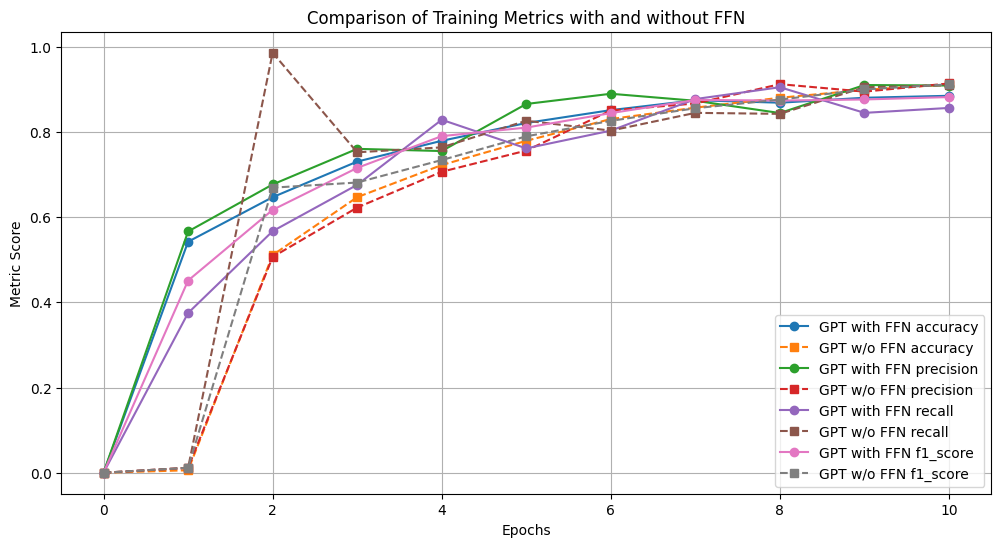

In [ ]:
import matplotlib.pyplot as plt
def plot_metrics_comparison(metrics_A, metrics_B, num_epochs):
    plt.figure(figsize=(12, 6))
    
    epochs = list(range(num_epochs+1))
    for metric in ["accuracy", "precision", "recall", "f1_score"]:
        plt.plot(epochs, metrics_A[metric], label=f"GPT with FFN {metric}", linestyle="-", marker="o")
        plt.plot(epochs, metrics_B[metric], label=f"GPT w/o FFN {metric}", linestyle="--", marker="s")

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Comparison of Training Metrics with and without FFN")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics_comparison(metric_with_FFN, metric_without_FFN, num_epochs=10)